Postavljanje okruženja

In [1]:
import pandas as pd
!pip install pandas openpyxl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/Google_historical_data.csv'

Mounted at /content/drive


Postavljanje dataseta:

* Dataset sadržava vrijednosti za svaki radni dan burze od 2015 do 2020
* Svaki redak sadržava datum i cijenu dionice na taj datum
* Svaki redak također sadržava cijenu dionice i ostale vrijednosti od prošlog radnog dana

In [2]:
data = pd.read_csv(file_path)

features_to_shift = [
    "Open", "High", "Low", "Close", "Adj_Close", "Volume",
    "Accumulation_Distribution_Line", "On_Balance_Volume",
    "Average_Directional_Index", "Aroon_Oscillator", "MACD",
    "RSI", "Stochastic_Oscillator", "Simple_Moving_Average",
    "Exponential_Moving_Average", "Williams_%R"
]

data['today_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)
data['prediction'] = data['today_price'] -  data['Adj_Close']
data['price_diff'] = data['prediction'].shift(1)

features_to_keep = [
    "Date","Open", "High", "Low", "Close", "Volume", "Adj_Close",
    "Accumulation_Distribution_Line", "On_Balance_Volume",
    "Average_Directional_Index", "Aroon_Oscillator", "MACD",
    "RSI", "Stochastic_Oscillator", "Simple_Moving_Average",
    "Exponential_Moving_Average", "Williams_%R", "prediction", 'today_price','price_diff'
]

data = data[features_to_keep]

data = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2020-01-01')]

Parametri koji će se koristiti kao input (X) varijabla za model:
* Lako možemo promijeniti ulazne varijable

In [3]:
indicators_to_keep = [
    "Open", "High", "Low", "Close", "Adj_Close","Volume",
    "Accumulation_Distribution_Line", "On_Balance_Volume",
    "Average_Directional_Index", "Aroon_Oscillator", "MACD",
    "RSI", "Stochastic_Oscillator", "Simple_Moving_Average",
    "Exponential_Moving_Average", "Williams_%R", 'price_diff'
]

Pomoću grid search tražimo najbolje parametre za model

In [4]:
#train_size = int(len(data) * 0.8)
#train_data = data.iloc[:train_size]
#test_data = data.iloc[train_size:]
#
#X_train = train_data[indicators_to_keep]
#y_train = train_data["prediction"]
#X_test = test_data[indicators_to_keep]
#y_test = test_data["prediction"]
#
#param_grid = {
#    'n_estimators': [50, 100, 200],
#    'max_depth': [None, 10, 20, 50, 100],
#    'min_samples_split': [2, 5, 10, 50, 100],
#    'min_samples_leaf': [1, 2, 4, 32, 64, 100],
#    'max_features': ['auto', 'sqrt', 'log2']
#}
#grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#
#grid_search.fit(X_train, y_train)
#
#best_params = grid_search.best_params_
#print("Best Hyperparameters:", best_params)
#
#best_model = grid_search.best_estimator_
#
#best_predictions = best_model.predict(X_test)
#
#mse_best = mean_squared_error(y_test, best_predictions)
#print("Mean Squared Error (Best Model):", mse_best)

Postavljanje modela i predviđanje cijene

In [5]:
train_size = int(len(data) * 0.8)

In [6]:
def walk_forward_validation_ann(data):
    actual_values = []
    predicted_values = []
    rmse_values = []
    for i in range(train_size, len(data)):
        train_data = data.iloc[:i+1]
        train_data = train_data[indicators_to_keep]
        test_data = train_data[i:]
        train_data = train_data[:i]

        X_train = train_data
        y_train = data.iloc[:i]["prediction"]
        X_test = test_data
        y_test = data.iloc[i:i+1]["prediction"]

        rf_model = RandomForestRegressor(max_depth= 50, max_features=None, min_samples_leaf=2, min_samples_split=50, n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        forecast = rf_model.predict(X_test)

        actual_values.append(y_test)
        predicted_values.append(forecast)
        value = mean_squared_error(y_test, forecast)
        value = np.sqrt(value)
        rmse_values.append(value)

    return predicted_values, actual_values, rmse_values

predicted_values, actual_values, rmse_values = walk_forward_validation_ann(data)

In [7]:
#train_size = int(len(data) * 0.8)
#train_data = data.iloc[:train_size]
#test_data = data.iloc[train_size:]
#
#X_train = train_data[indicators_to_keep]
#y_train = train_data["prediction"]
#X_test = test_data[indicators_to_keep]
#y_test = test_data["prediction"]
#
#rf_model = RandomForestRegressor(max_depth=20, max_features='auto', min_samples_leaf=1, min_samples_split=5, n_estimators=200, random_state=42)
#rf_model.fit(X_train, y_train)
#forecast = rf_model.predict(X_test)

Grafički prikaz

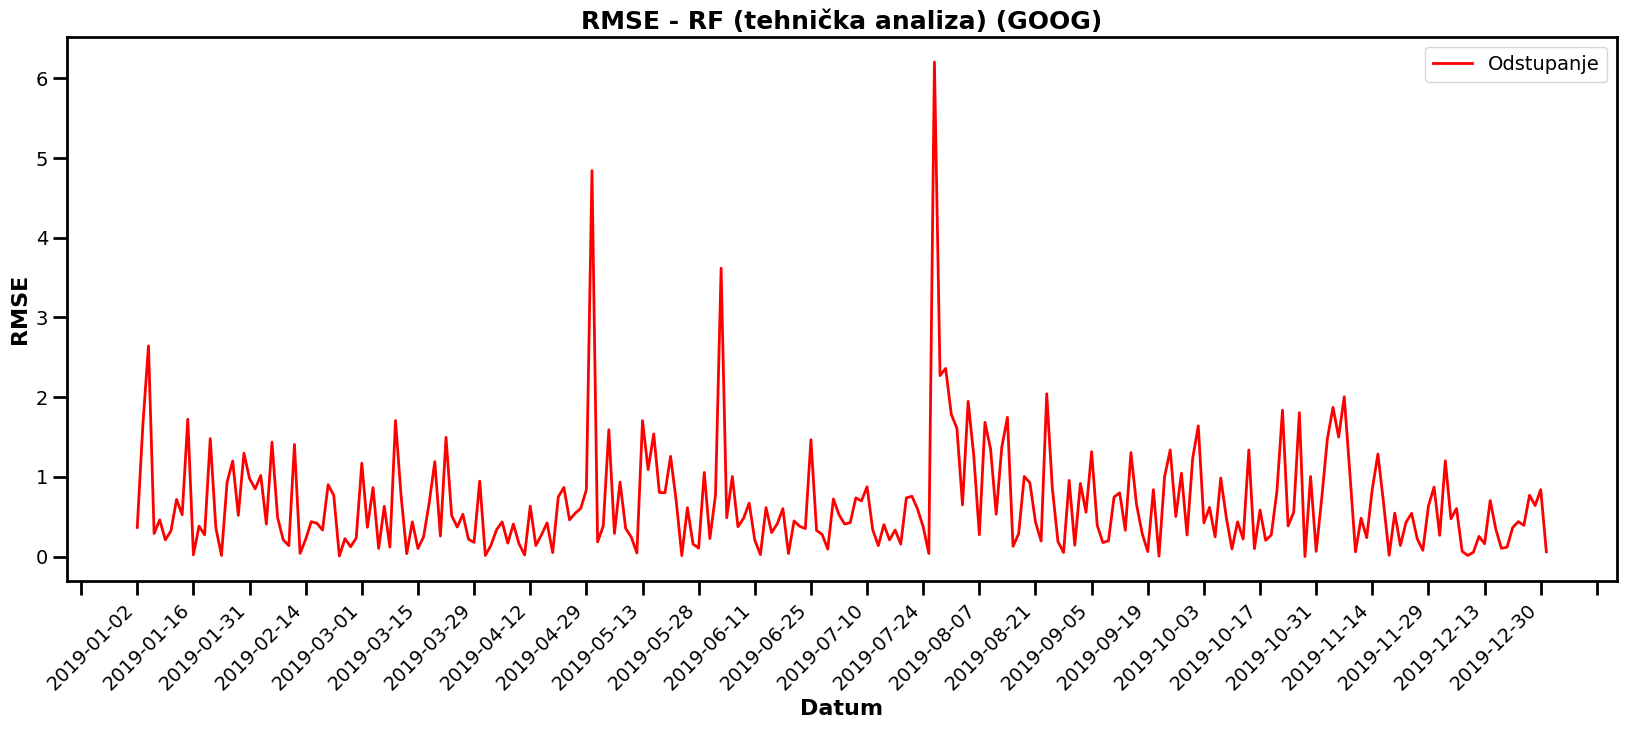

In [8]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot RMSE values with increased line thickness
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - RF (tehnička analiza) (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


In [9]:
excel = {
    'Date': plot_data["Date"],
    'price_diff': predicted_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'DT_ta_GOOG_price_diff_values.xlsx'
df.to_excel(excel_file_path, index=False)

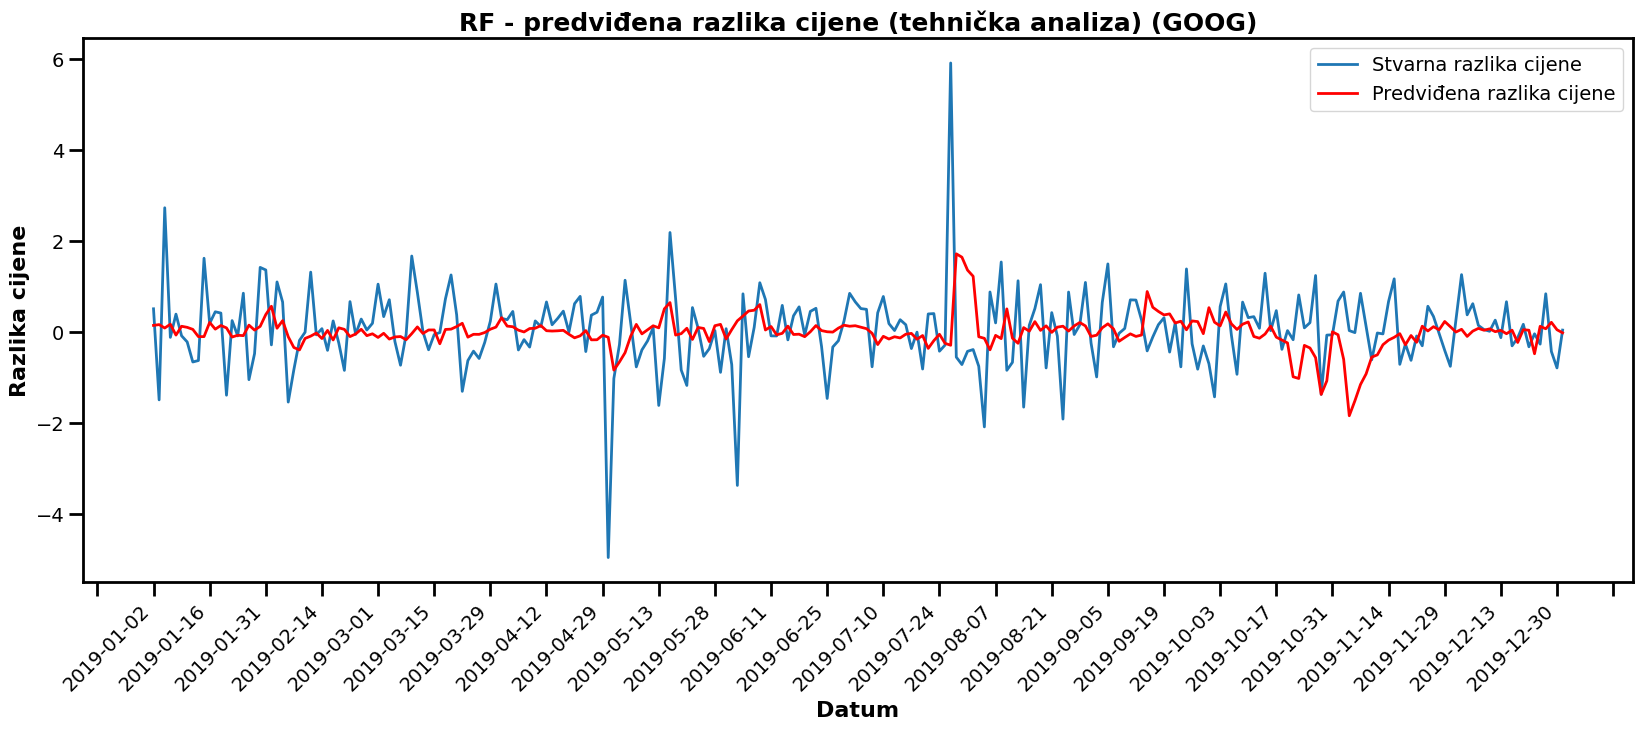

In [10]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

values = predicted_values

# Plot actual and predicted price differences with increased line thickness
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)
plt.plot(plot_data["Date"], values, label='Predviđena razlika cijene', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('RF - predviđena razlika cijene (tehnička analiza) (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


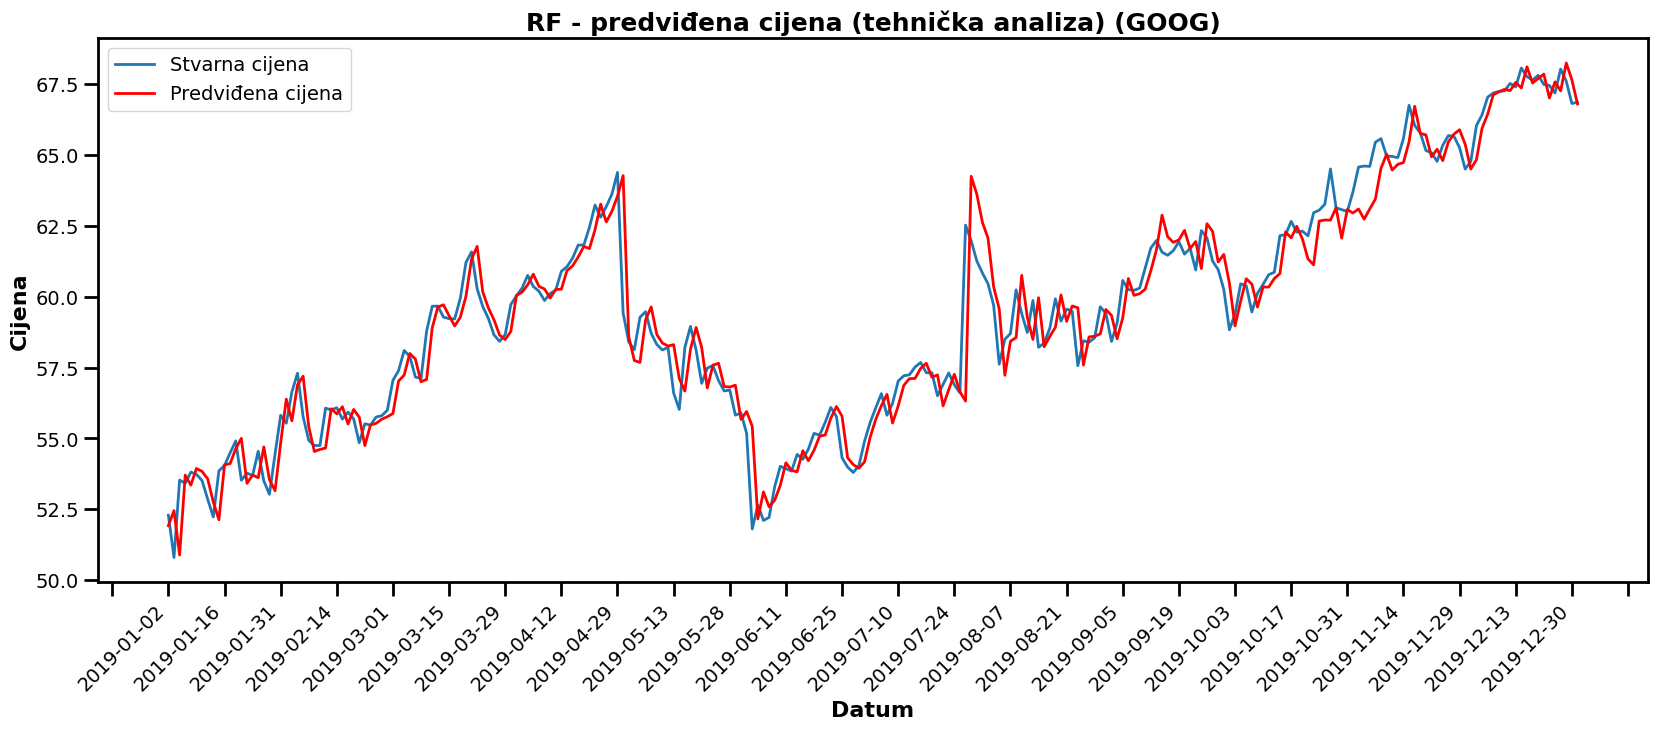

In [11]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = predicted_values
plot_data["Predicted_price"] = plot_data["Adj_Close"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot actual and predicted prices with increased line thickness
plt.plot(plot_data["Date"], plot_data["today_price"], label='Stvarna cijena', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('RF - predviđena cijena (tehnička analiza) (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()
